# First attempts with Scikit-image

## A brief summary
I used this notebook to get some sense of the simplicity of using scikit-image (`skimage`) for image segmentation and edge detection. <br>
Started following a few tutorials from skimage official website, I have tinkered with thresholds, edge detection, and color-space conversion.<br>
I selected a sample photo from our data `1B-B1N_10x.jpg` that has low contrast between the weld and the base material.<br>
Basic threshold applications didn't contribute to good edge detection as a single approach.<br>
Exploration of color-space conversion from RGB to HSV and ploting the different channels demonstrated benefits of the Hue channel in enhancing ROi/BG spectrum. From these I inferred that that it is worth exploring clustering and blurring of this channel as the next step.<br><br>
**Update 09-mar-2023**: I have decided to test OpenCV as Sarah showed quick and fast results for edge detection and houghline constructions. 

In [1]:
from skimage import data
from skimage.exposure import histogram
coins = data.coins()
hist, hist_centers = histogram(coins)

In [2]:
from matplotlib import pyplot as plt

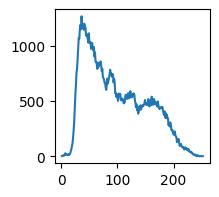

In [9]:
hist, hist_centers = histogram(coins)
plt.figure(figsize=(2,2))
plt.plot(hist_centers, hist)
plt.show()

# Thresholds and filters
Trying out different filter applications <br>
<br>
https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding_guide.html#sphx-glr-auto-examples-applications-plot-thresholding-guide-py

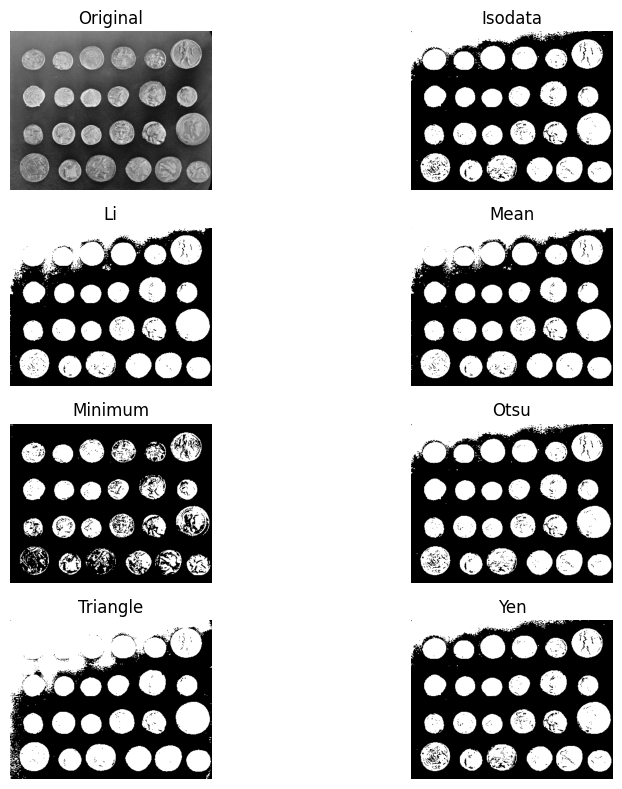

In [10]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(coins, figsize=(10, 8), verbose=False)
plt.show()

One can apply also a single threshold at a time

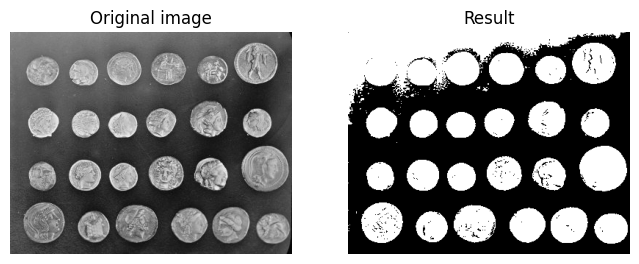

In [20]:
from skimage.filters import threshold_mean

thresh = threshold_mean(coins)
binary = coins > thresh

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(coins, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

## Bimodal histogram
For pictures with a bimodal histogram, more specific algorithms can be used. For instance, the minimum algorithm takes a histogram of the image and smooths it repeatedly until there are only two peaks in the histogram.

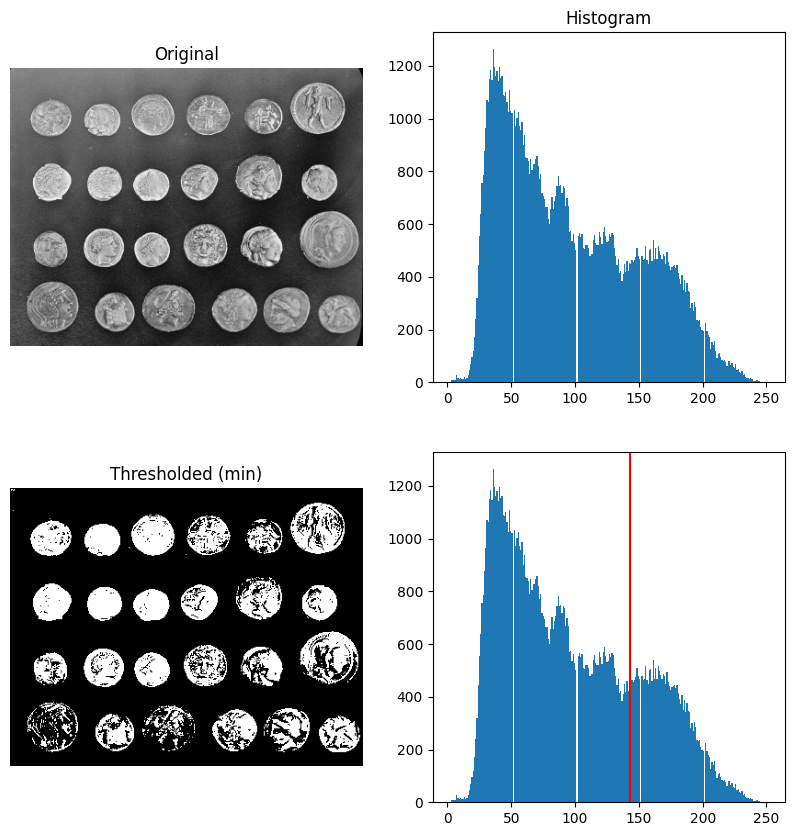

In [13]:
from skimage.filters import threshold_minimum


thresh_min = threshold_minimum(coins)
binary_min = coins > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(coins, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(coins.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(coins.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

Otsu’s method calculates an “optimal” threshold (marked by a red line in the histogram below) by maximizing the variance between two classes of pixels, which are separated by the threshold. Equivalently, this threshold minimizes the intra-class variance.

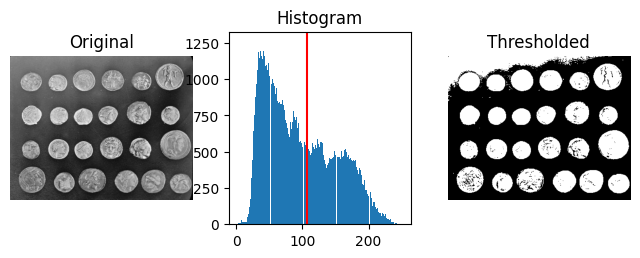

In [15]:
from skimage.filters import threshold_otsu


thresh = threshold_otsu(coins)
binary = coins > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(coins, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(coins.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

## Local Threshold

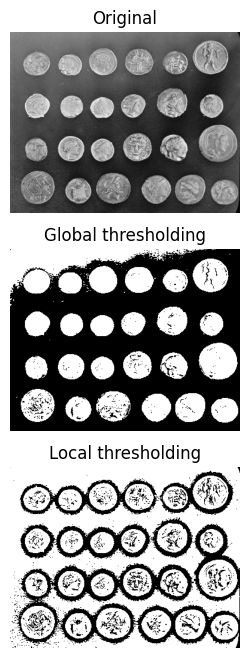

In [19]:
from skimage.filters import threshold_otsu, threshold_local


image = coins

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 35
local_thresh = threshold_local(image, block_size, offset=10)
binary_local = image > local_thresh

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

for a in ax:
    a.axis('off')

plt.show()

# Loading sample file from our database

In [3]:
from skimage import io
from skimage.color import rgb2gray
sample = io.imread("../data/interim/1B-B1N_10x.jpg")
sample_gr = rgb2gray(sample) 

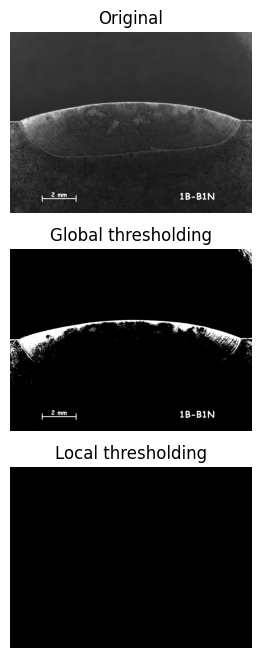

In [23]:

image = sample_gr

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 35
local_thresh = threshold_local(image, block_size, offset=10)
binary_local = image > local_thresh

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

for a in ax:
    a.axis('off')

plt.show()

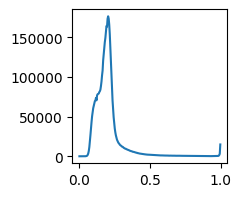

In [26]:
hist, hist_centers = histogram(sample_gr)
plt.figure(figsize=(2,2))
plt.plot(hist_centers, hist)
plt.show()

In [28]:
sample_gr.shape

(1936, 2584)

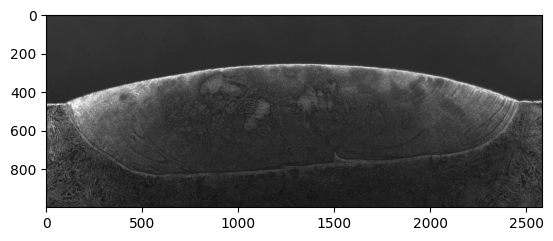

In [29]:
plt.imshow(sample_gr[500:1500])

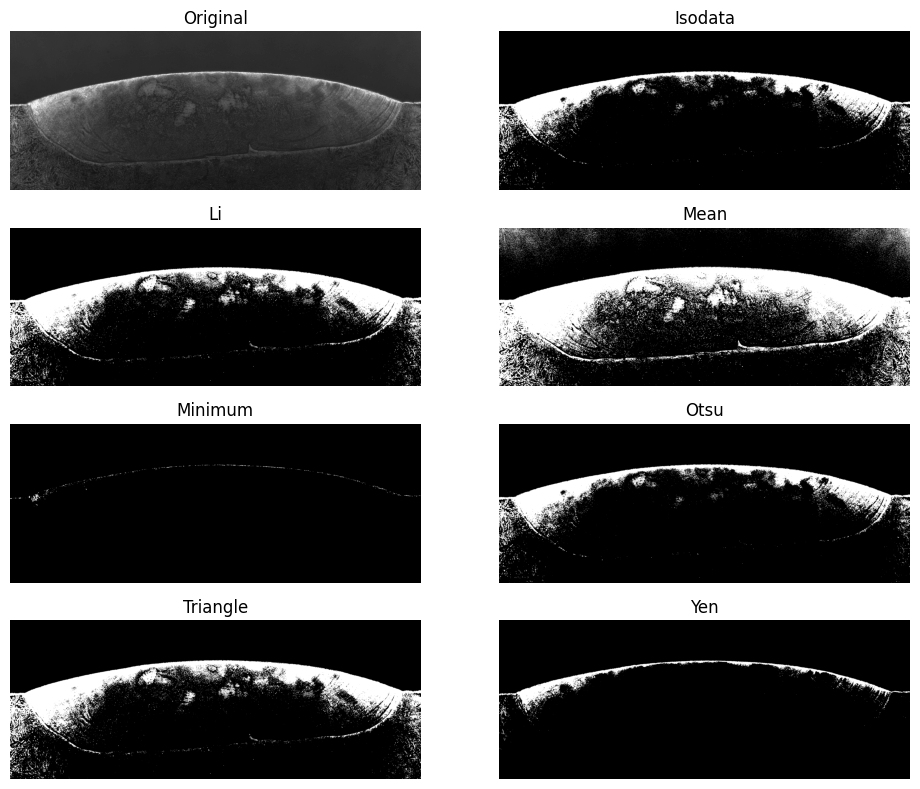

In [30]:
fig, ax = try_all_threshold(sample_gr[500:1500], figsize=(10, 8), verbose=False)
plt.show()

It seems from the result above, that there is no single threshold that can help identifying the penetration edge completely. Purhaps the edge can be found using two filters and then combining the results.

# Edge-based segmentation

In [22]:
from skimage.feature import canny
edges1 = canny(coins/255.)
edges2 = canny(coins/255., sigma=.3)

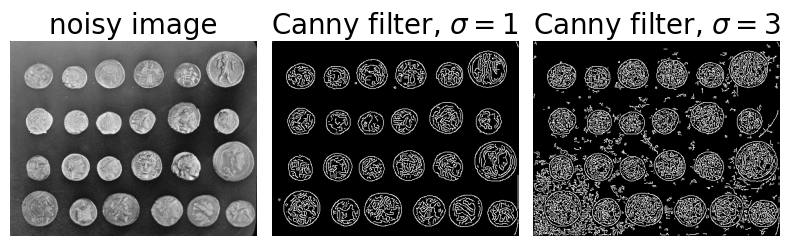

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(coins, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

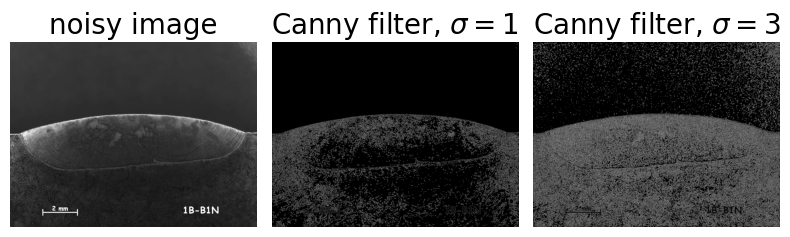

In [39]:
edges1 = canny(sample_gr)
edges2 = canny(sample_gr, sigma=.3)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(sample_gr, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

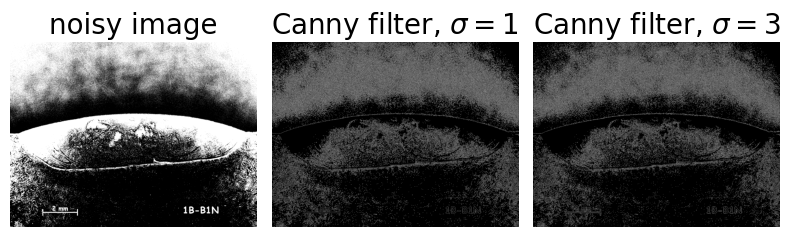

In [42]:

thresh = threshold_mean(sample_gr)
binary = sample_gr > thresh

edges1 = canny(binary)
edges2 = canny(binary, sigma=.3)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(binary, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

I used https://scikit-image.org/docs/stable/auto_examples/edges/plot_canny.html to plot canny edges

In [43]:
from scipy import ndimage as ndi
fill_coins = ndi.binary_fill_holes(edges)

In [45]:
import numpy as np

label_objects, nb_labels = ndi.label(fill_coins)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
coins_cleaned = mask_sizes[label_objects]

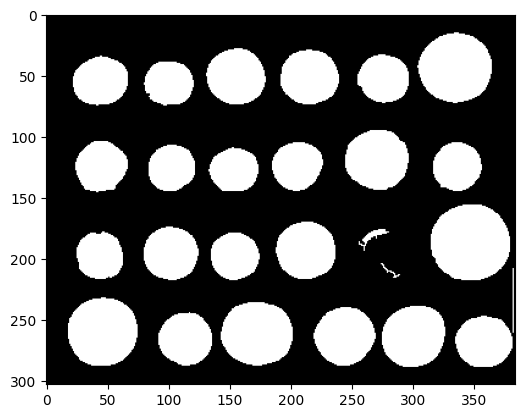

In [46]:
plt.imshow(coins_cleaned)

# Exploring color spectrum and separation

Since the applying thresholds on the original sample is not efficient, I have started to explore the effects of converting the color-space of the photo.

In [13]:
from skimage.color import rgb2hsv
sample_hsv = rgb2hsv(sample) 

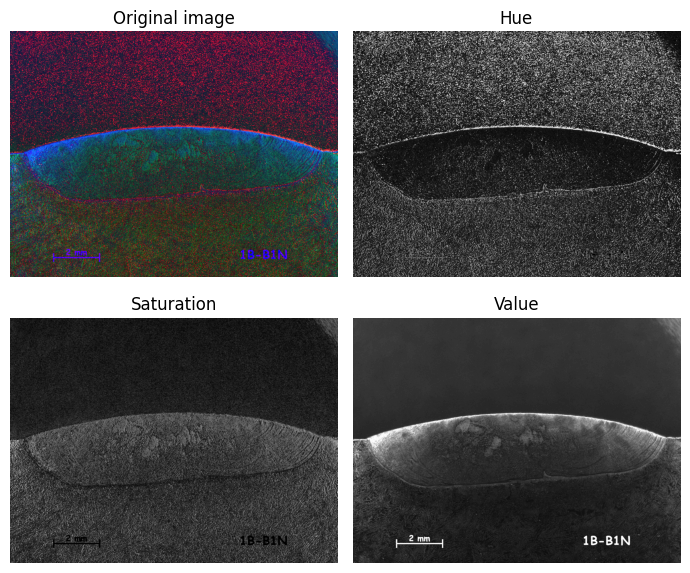

In [15]:
null = np.zeros_like(sample_hsv[:, :, 0])
hsv_h = np.stack((sample_hsv[:, :, 0], null, null), axis=-1)
hsv_s = np.stack((null, sample_hsv[:, :, 1], null), axis=-1)
hsv_v = np.stack((null, null, sample_hsv[:, :, 2]), axis=-1)
hsv_h_gr = rgb2gray(hsv_h)
hsv_s_gr = rgb2gray(hsv_s)
hsv_v_gr = rgb2gray(hsv_v)


# Display
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(sample_hsv)
ax[0].set_title("Original image")

ax[1].imshow(hsv_h_gr, cmap='gray')
ax[1].set_title("Hue")

ax[2].imshow(hsv_s_gr, cmap='gray')
ax[2].set_title("Saturation")  # Note that there is no Eosin stain in this image

ax[3].imshow(hsv_v_gr, cmap='gray')
ax[3].set_title("Value")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

It seems that the __Hue__ channel can help seperating the weld form the background. Plotting the histogram of this channel yields:

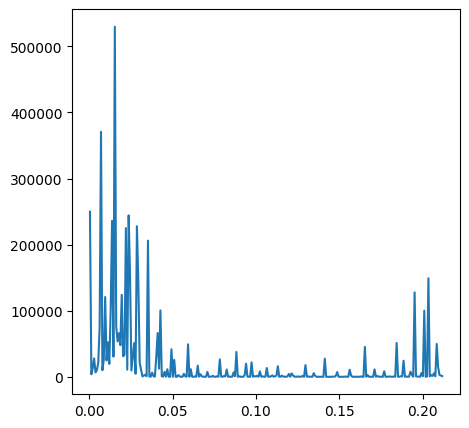

In [17]:

hist, hist_centers = histogram(hsv_h_gr)

plt.figure(figsize=(5,5))
plt.plot(hist_centers, hist)
plt.show()

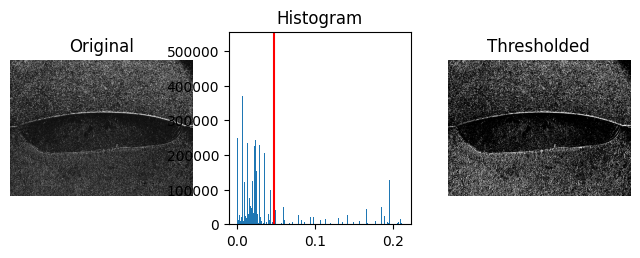

In [ ]:
from skimage.filters import threshold_otsu

image = hsv_h_gr
# thresh = threshold_otsu(image)
thresh = threshold_mean(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

Trying to invert the colors

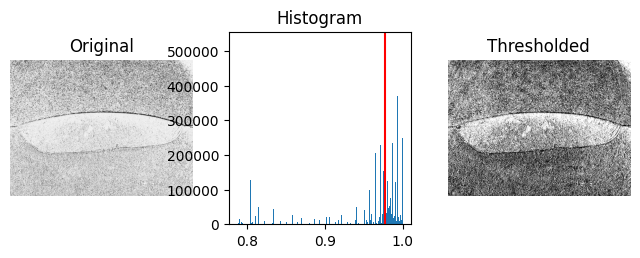

In [28]:
from skimage import util
from skimage.filters import threshold_triangle

image = util.invert(hsv_h_gr)
# thresh = threshold_otsu(image)
thresh = threshold_triangle(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

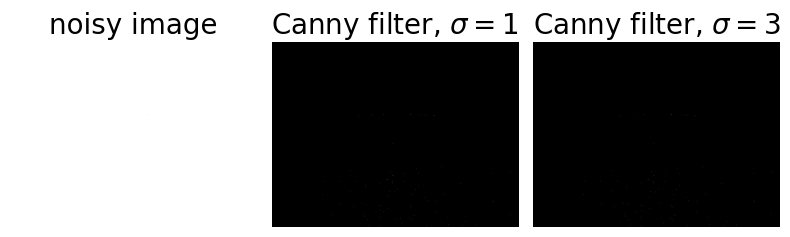

In [23]:
thresh = threshold_mean(hsv_h_gr)
binary = sample_gr > thresh

edges1 = canny(binary)
edges2 = canny(binary, sigma=.3)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(binary, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

In [7]:
from skimage.color import rgb2hed
sample_hed = rgb2hed(sample) 


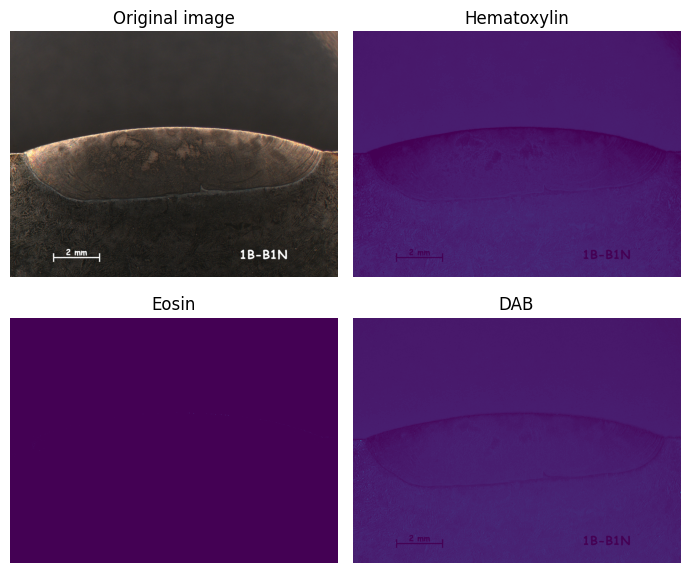

In [10]:
null = np.zeros_like(sample_hed[:, :, 0])
hed_h = np.stack((sample_hed[:, :, 0], null, null), axis=-1)
hed_e = np.stack((null, sample_hed[:, :, 1], null), axis=-1)
hed_d = np.stack((null, null, sample_hed[:, :, 2]), axis=-1)
hed_h_gr = rgb2gray(hed_h)
hed_e_gr = rgb2gray(hed_e)
hed_d_gr = rgb2gray(hed_d)


# Display
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(sample)
ax[0].set_title("Original image")

ax[1].imshow(hed_h_gr)
ax[1].set_title("Hematoxylin")

ax[2].imshow(hed_e_gr)
ax[2].set_title("Eosin")  # Note that there is no Eosin stain in this image

ax[3].imshow(hed_d_gr)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [9]:
import numpy as np

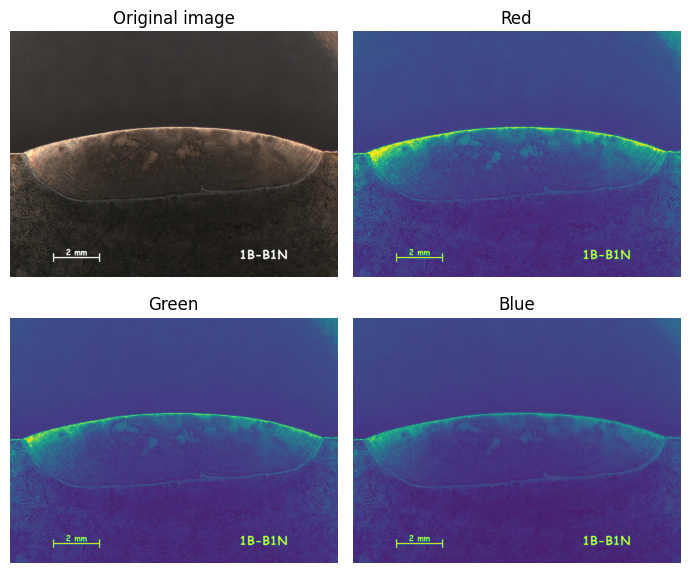

In [11]:
from skimage.color import rgb2hsv
null = np.zeros_like(sample[:, :, 0])
sample_r = np.stack((sample[:, :, 0], null, null), axis=-1)
sample_g = np.stack((null, sample[:, :, 1], null), axis=-1)
sample_b = np.stack((null, null, sample[:, :, 2]), axis=-1)
sample_r_gr = rgb2gray(sample_r)
sample_g_gr = rgb2gray(sample_g)
sample_b_gr = rgb2gray(sample_b)


# Display
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(sample)
ax[0].set_title("Original image")

ax[1].imshow(sample_r_gr)
ax[1].set_title("Red")

ax[2].imshow(sample_g_gr)
ax[2].set_title("Green")  # Note that there is no Eosin stain in this image

ax[3].imshow(sample_b_gr)
ax[3].set_title("Blue")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

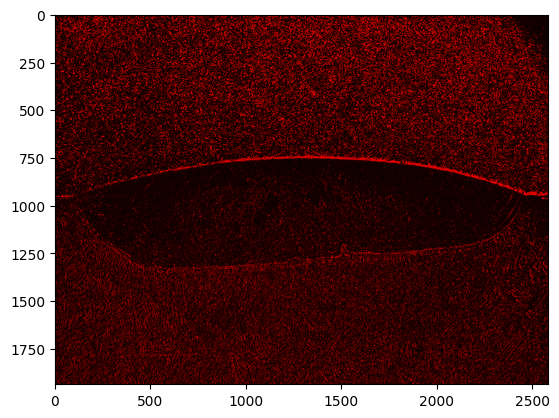

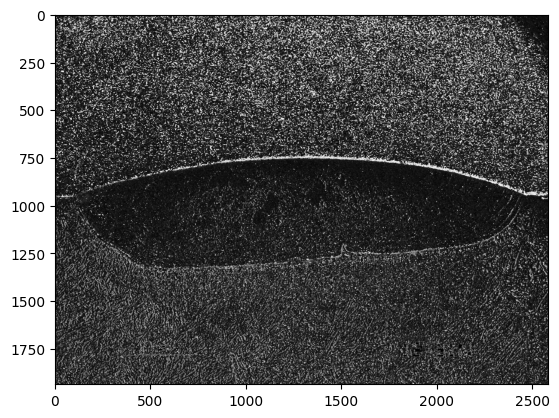

In [64]:
plt.imshow(hsv1)
plt.show()
plt.imshow(hsv1_gr)
plt.show()


In [54]:
sample_hsv.channel_axis)

AttributeError: 'numpy.ndarray' object has no attribute 'channel_axis'

# Attempts with segmentation using k-means - unsuccessful so far

In [33]:

image_gray= hsv_h_gr.reshape(hsv_h_gr.shape[0] * \
            hsv_h_gr.shape[1], 1)

In [35]:
from sklearn.cluster import KMeans
n=6
kmeans = KMeans(n_clusters=n, random_state=0).fit(image_gray)
clustered = kmeans.cluster_centers_[kmeans.labels_]

In [43]:

labels = kmeans.labels_
for n in range(n):
    image_cluster = []
    for i in range(len(labels)):
        if(labels[i]) == n:
            image_cluster.append(float(clustered[i]))
        else:
            image_cluster.append(1)
    if(n==1):
        image_fix= np.array(image_cluster).reshape(hsv_h_gr.shape)
    reshape_clustered = np.array(image_cluster).reshape(hsv_h_gr.shape)
    plt.imshow(reshape_clustered, cmap=plt.get_cmap("gray"),vmin=0, vmax=1)
    plt.show()

: 

In [42]:
clustered

array([[0.01023669],
       [0.01023669],
       [0.01023669],
       ...,
       [0.02424708],
       [0.02424708],
       [0.02424708]])

In [40]:
labels

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)